In [1]:
import os
# Set according to your compiler - this setting may be needed for Brian 2
os.environ["CC"] = "gcc"
os.environ["CXX"] = "g++"

import pysnnblaze as pb
import numpy as np
import time
import random
import math
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

In [2]:
# Execution threads
num_threads = 1

# Set to false to disable figure titles (cleaner output for reporting)
figure_titles = False

## Network setup
This network takes inspiration from the work by Maas et al. (2002). It emulates the topology of a cortical microcircuit by arranging neurons in a 3D lattice with a higher probability of connections between nearby neurons. A Gaussian function is used to define connection probabilities.

In [3]:
# Neuron parameters
tau_m = 20e-3       # membrane time constant [s]
C_m = 200e-12       # membrane capacitance [F]
v_rest = -70e-3     # resting potential [V]
v_reset = -70e-3    # reset potential after spike [V]
v_thresh = -50e-3   # threshold [V]
refractory = 5e-3   # refractory period [s]

neuron = pb.LIFNeuron(tau_m=tau_m, C_m=C_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

In [4]:
# Network parameters
weight_range_exc = (0.5e-3*C_m, 1.0e-3*C_m)
weight_range_inh = (-1.0e-3*C_m, -0.5e-3*C_m)
delay_range = (1.0e-3, 5.0-3)
network_shape = (5, 5, 8)  # 3D lattice dimensions (x, y, z)
num_neurons = network_shape[0] * network_shape[1] * network_shape[2]
num_inhibitory = int(0.2 * num_neurons)

# Define different sigma values for EE, EI, IE, II connections
sigma_EE = 2.0
sigma_EI = 2.0
sigma_IE = 2.5
sigma_II = 0.5

# Define neuron positions in a 3D lattice
positions = {}
i = 0 # neuron indices from 0 to num_neurons-1
for x in range(network_shape[0]):
    for y in range(network_shape[1]):
        for z in range(network_shape[2]):
            positions[i] = (x, y, z)
            i += 1

# Distance-based connection probability (Maas et al.-like)
def connection_probability(d, sigma):
    return math.exp(- (d ** 2) / (2 * sigma ** 2))

# Set random seed for reproducibility
random.seed(42)

all_neurons = list(range(num_neurons))
inh_neurons = set(random.sample(all_neurons, num_inhibitory))
exc_neurons = set(all_neurons) - inh_neurons

# Build graph
graph = []
for pre in range(num_neurons):
    for post in range(num_neurons):
        if pre != post:
            x1, y1, z1 = positions[pre]
            x2, y2, z2 = positions[post]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

            # Select sigma based on pre/post neuron types
            if pre in exc_neurons and post in exc_neurons:
                sigma_conn = sigma_EE
            elif pre in exc_neurons and post in inh_neurons:
                sigma_conn = sigma_EI
            elif pre in inh_neurons and post in exc_neurons:
                sigma_conn = sigma_IE
            else:  # pre in inh_neurons and post in inh_neurons
                sigma_conn = sigma_II

            # Distance-dependent connection probability
            prob = connection_probability(dist, sigma_conn)
            if random.random() < prob:
                # Assign weight based on pre-synaptic neuron type
                weight = random.uniform(*weight_range_inh) if pre in inh_neurons else random.uniform(*weight_range_exc)
                delay = random.uniform(*delay_range)
                graph.append((pre, post, weight, delay))

In [5]:

def plot_3d_network(positions, graph, inh_neurons, neuron_size=20, connection_alpha=0.3):
    """
    Plots a 3D neural network graph.

    Args:
        positions (dict): neuron positions {index: (x, y, z)}
        graph (list): list of connections [(pre, post, weight, delay), ...]
        num_inhibitory (int, optional): number of inhibitory neurons at the end of the list
        neuron_size (int): size of neuron scatter points
        connection_alpha (float): transparency of connection lines
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    total_neurons = len(positions)
        
    # Plot neurons
    inh_label_added = False
    exc_label_added = False

    for idx, (x, y, z) in positions.items():
        if idx in inh_neurons:
            label = 'Inhibitory' if not inh_label_added else ""
            ax.scatter(x, y, z, c='blue', s=neuron_size, label=label)
            inh_label_added = True
        else:
            label = 'Excitatory' if not exc_label_added else ""
            ax.scatter(x, y, z, c='red', s=neuron_size, label=label)
            exc_label_added = True


    # Plot connections
    for pre, post, weight, delay in graph:
        x_vals = [positions[pre][0], positions[post][0]]
        y_vals = [positions[pre][1], positions[post][1]]
        z_vals = [positions[pre][2], positions[post][2]]

        color = 'red' if weight > 0 else 'blue'
        ax.plot(x_vals, y_vals, z_vals, c=color, alpha=connection_alpha, linewidth=1)

    # Labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Neural Network Graph')

    # Set integer ticks for all axes
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.zaxis.set_major_locator(MaxNLocator(integer=True))

    ax.legend()
    plt.show()

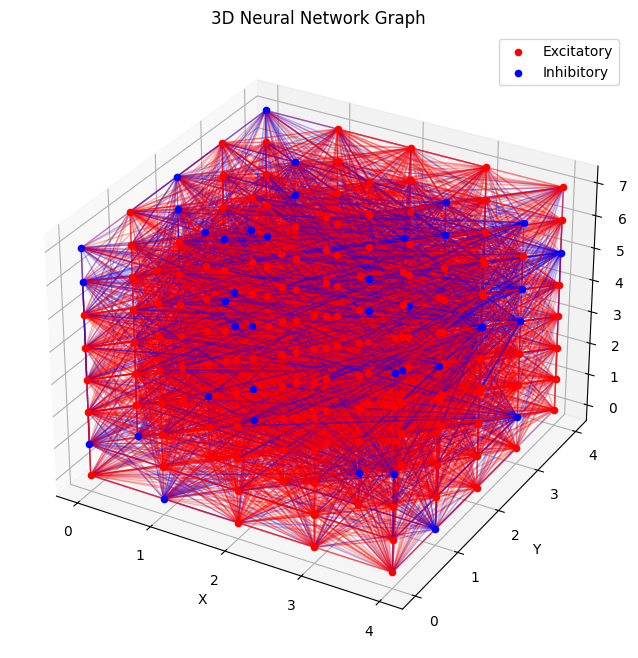

In [6]:
plot_3d_network(positions, graph, inh_neurons)

## Spiking Heidelberg Digits

### Loading the dataset

In [7]:
shd_train_filepath = '../data/shd_train.h5'
shd_train_filepath = '../data/shd_test.h5'

with h5py.File('../data/shd_train.h5', 'r') as f:
    print("Top-level groups/datasets:", list(f.keys()))
    print(f['labels']) # Classes
    print(f['spikes/times']) # Spike times
    print(f['spikes/units']) # Neuron indices

    train_labels = f['labels'][:]
    train_spike_times = f['spikes/times'][:]
    train_neuron_indices = f['spikes/units'][:]

with h5py.File('../data/shd_test.h5', 'r') as f:
    test_labels = f['labels'][:]
    test_spike_times = f['spikes/times'][:]
    test_neuron_indices = f['spikes/units'][:]

Top-level groups/datasets: ['extra', 'labels', 'spikes']
<HDF5 dataset "labels": shape (8156,), type "<u2">
<HDF5 dataset "times": shape (8156,), type "|O">
<HDF5 dataset "units": shape (8156,), type "|O">


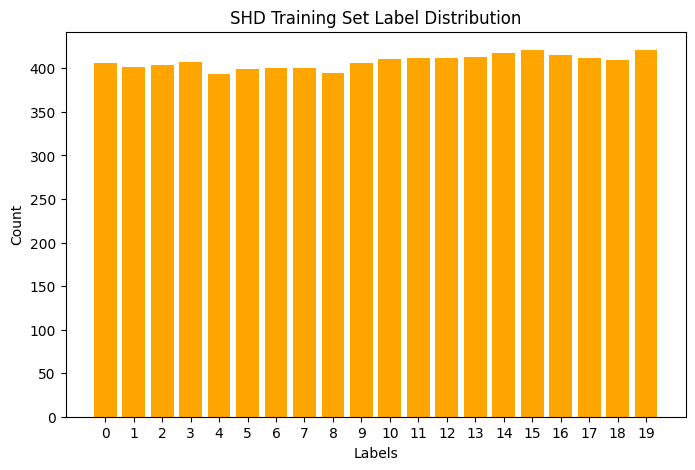

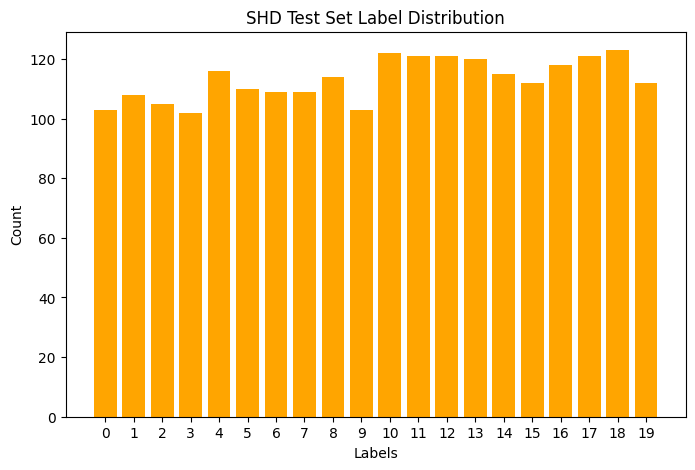

In [8]:
def plot_label_distribution(labels, title="Label Distribution", xlabel="Labels", ylabel="Count", color='orange'):
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    counts = np.array([np.sum(labels == ul) for ul in unique_labels])

    plt.figure(figsize=(8, 5))
    plt.bar(unique_labels, counts, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(unique_labels)
    plt.show()

plot_label_distribution(train_labels, title='SHD Training Set Label Distribution')
plot_label_distribution(test_labels, title='SHD Test Set Label Distribution')

In [9]:
train_spike_times[0].shape
train_neuron_indices[0].shape

train_spike_events = []

for i in range(train_spike_times.shape[0]):
    events = np.stack((train_spike_times[i], train_neuron_indices[i]), axis=-1)
    train_spike_events.append(events)

In [10]:
def plot_raster(spikes, title="Raster Plot"):
    # Unpack spikes into separate lists
    time = spikes[:,0]
    neurons = spikes[:,1]

    plt.figure(figsize=(10, 6))
    plt.scatter(time, neurons, s=1, c='black')
    plt.xlabel("Time")
    plt.ylabel("Neuron")
    plt.title(title)
    plt.show()

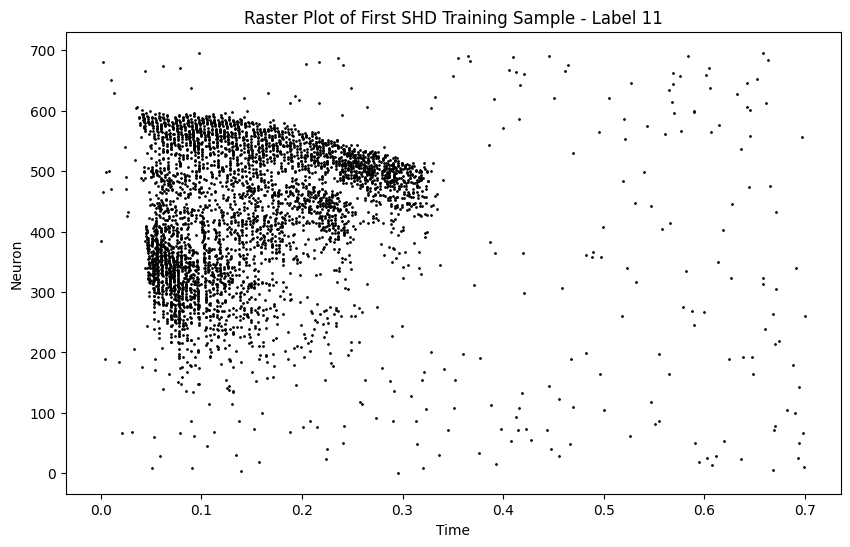

In [11]:
label = train_labels[0]
plot_raster(train_spike_events[0], title=f'Raster Plot of First SHD Training Sample - Label {label}')

### Simulating network and retrieving results

In [12]:
# Initialize network and monitors
start_time = time.perf_counter()
nn = pb.NeuralNetwork()
nn.set_num_exec_threads(num_threads)
spike_monitor = pb.SpikeMonitor()
nn.set_spike_monitor(spike_monitor)
state_monitor = pb.StateMonitor(100e-6)
nn.set_state_monitor(state_monitor)
nn.add_neuron_population(num_neurons, neuron)

# Instantiate the graph into the neural network
for pre, post, weight, delay in graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

end_time = time.perf_counter()
print(f"Setup finished in {end_time - start_time:.6f} seconds")

Setup finished in 0.013730 seconds


In [13]:
class InputLayer:
    def __init__(self, num_in, num_res, p_in):
        self.num_in = num_in
        self.num_res = num_res
        self.p_in = p_in  # connection probability

        # Initialize weight and delay matrices
        self.weight_mat = np.zeros((num_in, num_res))
        self.delay_mat = np.zeros((num_in, num_res))

        # Generate random connections
        for i in range(num_in):
            for j in range(num_res):
                if np.random.rand() < p_in:
                    self.weight_mat[i, j] = np.random.uniform(0.5e-3*C_m, 1.0e-3*C_m)
                    self.delay_mat[i, j] = np.random.uniform(1.0e-3, 2.0e-3)  # ms

    def input_to_reservoir(self, nn, spike_events):
        '''
        nn: snnblaze NeuralNetwork instance
        spike_events: array of shape (num_spikes, 2) with columns [spike_time, neuron_index]
        '''
        for spike_time, neuron_index in spike_events:
            neuron_index = int(neuron_index)
            for res_neuron in range(self.num_res):
                weight = self.weight_mat[neuron_index, res_neuron]
                delay = self.delay_mat[neuron_index, res_neuron]
                nn.schedule_spike_event(spike_time + delay, res_neuron, weight)

In [14]:
inp_layer = InputLayer(num_in=700, num_res=num_neurons, p_in=0.1)

# Add input spikes for the first training sample
inp_layer.input_to_reservoir(nn, train_spike_events[0])

nn.run(2.0)

In [15]:

np.array(spike_monitor.spike_list).shape

(1123, 2)

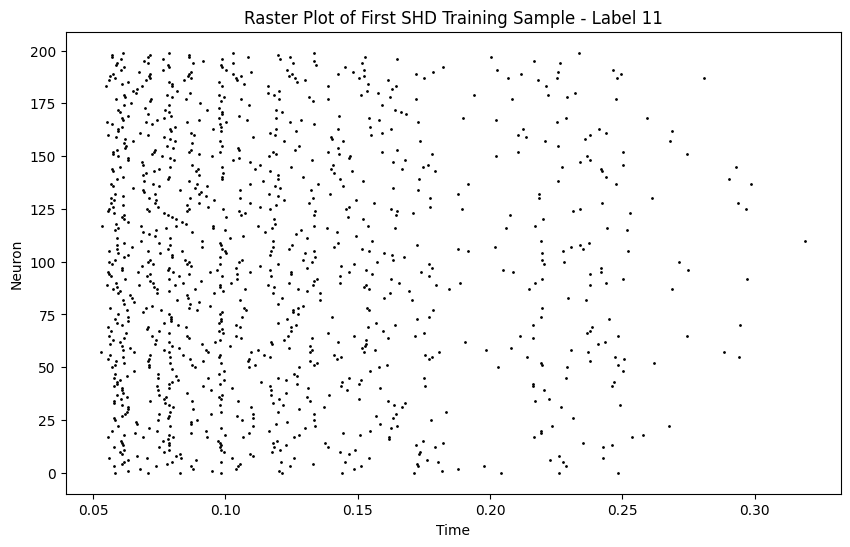

In [16]:
spike_monitor.spike_list
plot_raster(np.array(spike_monitor.spike_list), title=f'Raster Plot of First SHD Training Sample - Label {label}')